Mounted at /content/drive
Head:
   sensor_index   sensor_id  timestamp_since_poweron  real_time_clock  \
0             0  1607616095                     4768       1722344704   
1             1  1607614553                     4773       1722344704   
2             2  1607619442                     4778       1722344704   
3             3  1607617650                     4782       1722344704   
4             4  1607616838                     4786       1722344704   
5             5  1607624558                     4791       1722344704   
6             6  1607630175                     4795       1722344704   
7             7  1607637077                     4799       1722344704   
8             0  1607616095                     5048       1722344704   
9             1  1607614553                     5052       1722344704   

   temperature     pressure  relative_humidity  resistance_gassensor  \
0    20.366257  1017.746155          54.910965          19008.019531   
1    19.792271  1017

,mean_temperature,mean_pressure,mean_relative_humidity,mean_resistance_gassensor,std_temperature,std_pressure,std_relative_humidity,std_resistance_gassensor
target,,,,,,,,
0,32.586569,1018.986203,27.201543,2.063933e+06,2.196640,0.314036,2.746539,4.143031e+06
1,32.407868,1014.842880,29.574995,8.761549e+05,1.469136,0.610774,2.571569,1.794592e+06
2,33.447016,1019.182571,27.960226,1.591236e+06,1.293004,0.325611,2.662041,3.304589e+06
3,32.112322,1021.392775,34.459316,8.480663e+05,1.254205,0.360843,2.800015,1.590610e+06


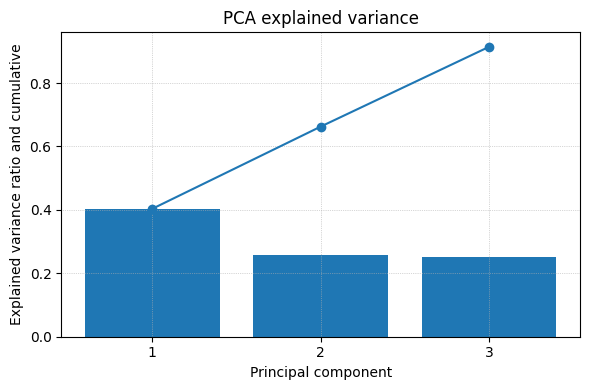

Explained variance ratio:
PC1: 0.4033
PC2: 0.2592
PC3: 0.2516


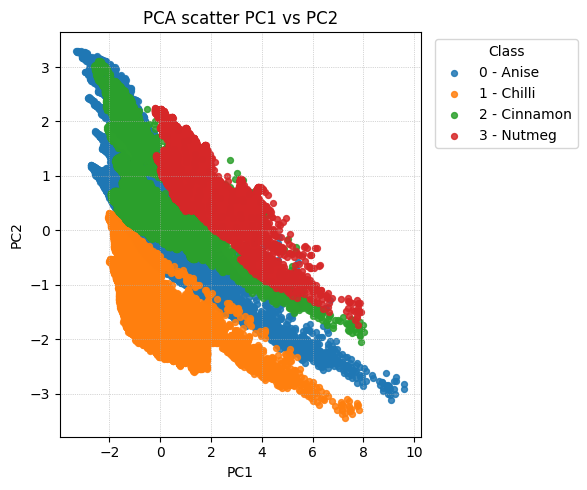

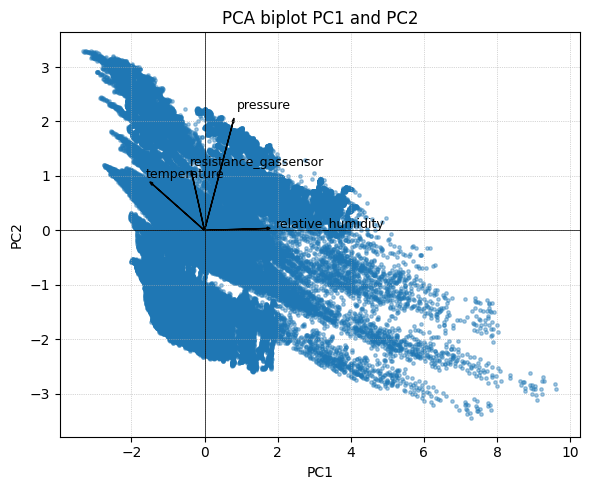

PCA loadings saved to: /content/pca_outputs/pca_loadings.csv
Outputs directory: /content/pca_outputs


In [1]:
# BME688 Electronic Nose PCA in Colab
# Dataset columns used:
#   Features: temperature, pressure, relative_humidity, resistance_gassensor
#   Label: target  (0 = Anise, 1 = Chilli, 2 = Cinnamon, 3 = Nutmeg)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = '/content/drive/MyDrive/Final_Year_Project/PCA/master_training_labeled.csv'  # change if your filename is different
OUTDIR = '/content/pca_outputs'
os.makedirs(OUTDIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

print("Head:")
print(df.head(10))

print("Shape:")
print(df.shape)

feature_cols = ["temperature", "pressure", "relative_humidity", "resistance_gassensor"]
label_col = "target"
missing = [c for c in feature_cols + [label_col] if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

before = len(df)
df = df.dropna(subset=feature_cols + [label_col])
df = df[np.isfinite(df[feature_cols]).all(axis=1)]
after = len(df)
if after < before:
    print(f"Dropped {before - after} rows due to missing or non-finite values.")

uniq_labels = np.sort(df[label_col].dropna().unique())
if not np.all(np.isin(uniq_labels, [0, 1, 2, 3])):
    raise ValueError(f"Label values in target must be 0, 1, 2, 3. Found: {uniq_labels}")

label_names = {0: "Anise", 1: "Chilli", 2: "Cinnamon", 3: "Nutmeg"}

dups = df.duplicated(subset=feature_cols + [label_col]).sum()
print("Duplicate rows on features + target:", dups)

print("Class counts:")
class_counts = df[label_col].value_counts().sort_index()
for k, v in class_counts.items():
    print(f"{k} - {label_names.get(int(k), str(k))}: {v}")

def per_class_stats(df, label_col, feature_cols):
    grouped = df.groupby(label_col)[feature_cols]
    means = grouped.mean().add_prefix("mean_")
    stds = grouped.std(ddof=0).add_prefix("std_")
    return pd.concat([means, stds], axis=1)

stats = per_class_stats(df, label_col, feature_cols)
stats_path = os.path.join(OUTDIR, "per_class_stats.csv")
stats.to_csv(stats_path, index=True)
print(f"Per class stats saved to: {stats_path}")
display(stats)

X = df[feature_cols].to_numpy(dtype=float)
y = df[label_col].to_numpy(dtype=int)

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

n_components = 3
pca = PCA(n_components=n_components, random_state=0)
Xp = pca.fit_transform(Xz)

plt.figure(figsize=(6, 4))
x = np.arange(1, len(pca.explained_variance_ratio_) + 1)
plt.bar(x, pca.explained_variance_ratio_)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio and cumulative")
plt.title("PCA explained variance")
plt.xticks(x)
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
ev_path = os.path.join(OUTDIR, "pca_explained_variance.png")
plt.savefig(ev_path, dpi=200)
plt.show()

print("Explained variance ratio:")
for i, r in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {r:.4f}")

if Xp.shape[1] >= 2:
    plt.figure(figsize=(6, 5))
    for lab in sorted(np.unique(y)):
        mask = y == lab
        plt.scatter(Xp[mask, 0], Xp[mask, 1], s=18, alpha=0.85, label=f"{lab} - {label_names.get(int(lab), str(lab))}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA scatter PC1 vs PC2")
    plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.tight_layout()
    sc_path = os.path.join(OUTDIR, "pca_scatter_pc1_pc2.png")
    plt.savefig(sc_path, dpi=200)
    plt.show()

if Xp.shape[1] >= 2:
    plt.figure(figsize=(6, 5))
    plt.scatter(Xp[:, 0], Xp[:, 1], s=6, alpha=0.4)
    comps = pca.components_
    arrow_scale = 2.5
    for i, feat in enumerate(feature_cols):
        plt.arrow(0, 0, comps[0, i] * arrow_scale, comps[1, i] * arrow_scale,
                  head_width=0.05, head_length=0.08, length_includes_head=True)
        plt.text(comps[0, i] * arrow_scale * 1.08,
                 comps[1, i] * arrow_scale * 1.08,
                 feat, fontsize=9)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA biplot PC1 and PC2")
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.tight_layout()
    bi_path = os.path.join(OUTDIR, "pca_biplot_pc1_pc2.png")
    plt.savefig(bi_path, dpi=200)
    plt.show()

loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)
loadings_path = os.path.join(OUTDIR, "pca_loadings.csv")
loadings.to_csv(loadings_path)
print(f"PCA loadings saved to: {loadings_path}")

print(f"Outputs directory: {OUTDIR}")
